#I assume the following kaggle data zipefiles are in the working directory



1.   train.csv.zip
2.   test.csv.zip
3.   test_labels.csv.zip


#Import libraries

In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, accuracy_score
from copy import deepcopy
import tensorflow as tf


#Extract zipfiles

In [ ]:

zip_train = ZipFile('train.csv.zip')
zip_train.extractall()

zip_test = ZipFile('test.csv.zip')
zip_test.extractall()

zip_testlabels = ZipFile('test_labels.csv.zip')
zip_testlabels.extractall()

#Read, filter and preprocess dataset

In [ ]:
df_test = pd.read_csv('test.csv')
df_testlabels = pd.read_csv('test_labels.csv')


#Filter by rows used for scoring
df_test_final = df_testlabels[(df_testlabels['toxic'] != -1) & (df_testlabels['severe_toxic'] != -1) & (df_testlabels['obscene'] != -1) &
                              (df_testlabels['threat'] != -1) & (df_testlabels['insult'] != -1) & (df_testlabels['identity_hate'] != -1)]

#Add the comment text to the labels dataset
df_test_final['comment_text'] = df_test[df_test['id'].isin(df_testlabels['id'])]['comment_text']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Read training data
train = pd.read_csv('train.csv')

#Use half the dataset due to ram constraints
train = train[0:80000]

In [ ]:
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[target_columns].values
list_sentences_train = train["comment_text"]
list_sentences_test = df_test_final["comment_text"]

In [ ]:
#Turn texts into sequences

#Use 20000 features because it's a high number but not too high
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

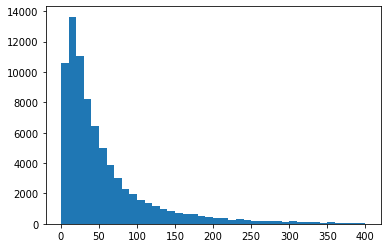

In [ ]:
#We need to set the max length of the sentences in the comments so we plot
#the distribution of words in the sentences to set the parameter

import matplotlib.pyplot as plt
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [ ]:
#250 seems like a good number from the plot above
maxlen = 250

#Pad sentences with 0s which are not 250 words long
x_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

#Model creation

I used manual embeddings for this case as the problem is very contextual and we are classifying hate speech. It should perform better than using external embeddings from GloVe, word2vec or Spacy.

Moreover, I use an LSTM over a CNN because the categories besides toxic and severe_toxic have long term semantic features which can be used to detect them and an LSTM works better for contextual/semantic dependent classifications than CNNs.

In [ ]:
#Create our model architecture

inp = Input(shape=(maxlen, ))
embed_size = 256

#Embedding layer to vectorize our data
x = Embedding(max_features, embed_size)(inp)

#Add the LSTM layer
x = LSTM(60, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)

#Add dropout to avoid overfitting
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)

#Add dropout to avoid overfitting
x = Dropout(0.2)(x)

#Sigmoid activation due to multi-label classification
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

#Binary cross entropy due to it being a multi-label classification problem
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 256)          5120000   
_________________________________________________________________
lstm (LSTM)                  (None, 250, 60)           76080     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [ ]:
#I don't train the model for long since this notebook is just
#to showcase understanding of deep learning

epochs = 5
batch_size = 30

weights_path ="best_weights.hdf5"
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early]
history = model.fit(x_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.15, callbacks=callbacks_list)

Epoch 1/5
2267/2267 [==============================] - 187s 68ms/step - loss: 0.1277 - accuracy: 0.7522 - val_loss: 0.0527 - val_accuracy: 0.9940

Epoch 00001: val_loss improved from inf to 0.05274, saving model to best_weights.hdf5
Epoch 2/5
2267/2267 [==============================] - 154s 68ms/step - loss: 0.0475 - accuracy: 0.9843 - val_loss: 0.0493 - val_accuracy: 0.9940

Epoch 00002: val_loss improved from 0.05274 to 0.04929, saving model to best_weights.hdf5
Epoch 3/5
2267/2267 [==============================] - 154s 68ms/step - loss: 0.0403 - accuracy: 0.9706 - val_loss: 0.0499 - val_accuracy: 0.9921

Epoch 00003: val_loss did not improve from 0.04929
Epoch 4/5
2267/2267 [==============================] - 153s 68ms/step - loss: 0.0351 - accuracy: 0.9351 - val_loss: 0.0524 - val_accuracy: 0.9939

Epoch 00004: val_loss did not improve from 0.04929
Epoch 5/5
2267/2267 [==============================] - 153s 67ms/step - loss: 0.0299 - accuracy: 0.8559 - val_loss: 0.0563 - val_accur

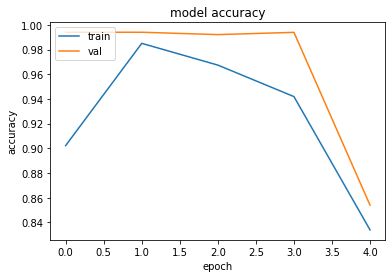

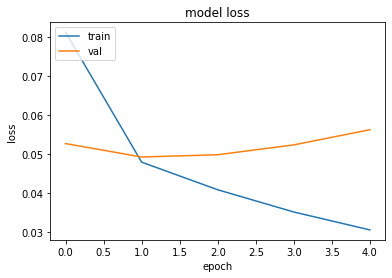

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Calculating AUC of ROC for the deep learning model

The results are extremely similar to the results of the logistic regression; but again, this model requires much more training and and fine tuning which may or may not be worth it depending on the time/resource limits and context (for example, if we were detecting some diseases in an x-ray/MRI, a 0.2% increase in accuracy should be worth it since we are making something that impacts human lives)

In [ ]:
#Make predictions on training set
preds_train = model.predict(x_train)

#Make predictions on test set
preds_test = model.predict(x_test)

In [ ]:
auc_train = ['Training data']
auc_test = ['Testing data']

for i, target in zip(range(len(preds_train[0])),target_columns):
  y_pred_prob_train = [x[i] for x in preds_train]
  y_pred_prob_test = [x[i] for x in preds_test]
  auc_train.append(roc_auc_score(train[target],y_pred_prob_train))
  auc_test.append(roc_auc_score(df_test_final[target],y_pred_prob_test))

  


In [ ]:
auc_table = pd.DataFrame([auc_train,auc_test],columns=['Data type','Toxic AUC','Severe Toxic AUC',
                                   'Obscene AUC','Threat AUC','Insult AUC','Identity Hate AUC'])

auc_table

,Data type,Toxic AUC,Severe Toxic AUC,Obscene AUC,Threat AUC,Insult AUC,Identity Hate AUC
0,Training data,0.993421,0.994653,0.996532,0.992630,0.993250,0.991102
1,Testing data,0.954966,0.984569,0.970383,0.977536,0.962457,0.963817
